In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import torchvision
#from torchsummary import summary
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist
from skimage.filters import gaussian

import time
import copy

# Reading data and creating targets

## Reading data

In [2]:
import os
os.chdir('/home/raes/Project2')

In [3]:
Nx, Ny = Image.open("data/labelled/"+os.listdir("data/labelled/")[1]).size
Nx

1014

In [4]:
for id_image in os.listdir('data/labelled/'):
    new=id_image.replace('_LI','')
    os.rename('data/labelled/'+id_image, 'data/labelled/'+new)

In [5]:
images=[]
raw_images=[]
stock_id = []
i=0
for id_image in os.listdir('data/raw/'):
    if  os.path.isfile('data/labelled/'+'Inked'+id_image):
        if os.path.isfile('data/raw/'+id_image):
            if np.shape(np.array(Image.open('data/labelled/'+'Inked'+id_image))) == (Nx,Ny,3):
                if np.shape(np.array(Image.open('data/raw/'+id_image))) == (Nx,Ny,3):
                    images.append( np.array(Image.open('data/labelled/'+'Inked'+ id_image)))
                    raw_images.append(np.array(Image.open('data/raw/'+id_image)))
                    stock_id.append(id_image)
                    
    i+=1
images=np.array(images)
raw_images=np.array(raw_images)
print(len(images))
print(len(raw_images))

369
369


## Creating targets
Localize the red and green dots and make them white on a black background.

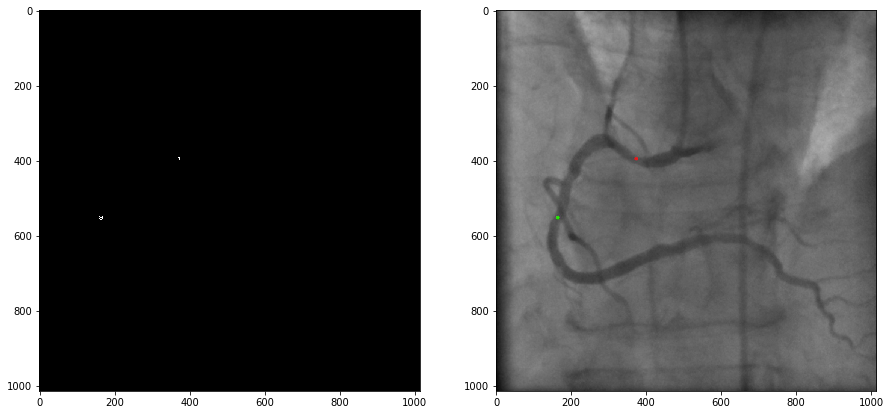

In [6]:


def binarize_RGB(im_np):
#GD_Rtresh: Green Dot Red channel tresholds [min, max]
    GD_Rtresh=[32,89] 
    GD_Gtresh=[86,233]
    GD_Btresh=[0,73]

    RD_Rtresh=[81,232]
    RD_Gtresh=[25,50]
    RD_Btresh=[21,51]


    GD_im_bin_R = (GD_Rtresh[0]<im_np[:,:,0]) & (im_np[:,:,0]<GD_Rtresh[1])
    GD_im_bin_G = (GD_Gtresh[0]<im_np[:,:,1]) & (im_np[:,:,1]<GD_Gtresh[1])
    GD_im_bin_B = (GD_Btresh[0]<im_np[:,:,2]) & (im_np[:,:,2]<GD_Btresh[1])
    #if (GD_im_bin_R & GD_im_bin_G & GD_im_bin_B).all() == False: print('GD pas détecté' )
    GD_im_bin = (GD_im_bin_R & GD_im_bin_G & GD_im_bin_B) * 255
    
    RD_im_bin_R = (RD_Rtresh[0]<im_np[:,:,0]) & (im_np[:,:,0]<RD_Rtresh[1])
    RD_im_bin_G = (RD_Gtresh[0]<im_np[:,:,1]) & (im_np[:,:,1]<RD_Gtresh[1])
    RD_im_bin_B = (RD_Btresh[0]<im_np[:,:,2]) & (im_np[:,:,2]<RD_Btresh[1])
    #if (RD_im_bin_R & RD_im_bin_G & RD_im_bin_B).all()  == False: print('RD pas détecté' )
    RD_im_bin = (RD_im_bin_R & RD_im_bin_G & RD_im_bin_B) * 255
    im_bin=GD_im_bin+RD_im_bin
    return im_bin

fig,ax=plt.subplots(1,2,figsize=[15,15])
im_bin=binarize_RGB(images[96])

ax[0].imshow(im_bin, cmap='gray')
ax[1].imshow(images[96])
plt.show()

### binarize a black and white image to binary 0/1 image
def binarize_BW(im_np):
    tresh=3*10e-20
    im_bin=(tresh<im_np)*1
    return im_bin

### Determine of the number of culprit region via clustering
After determining the number of culprit regions, different images are created, each only containing 1 labelled culprit region. This is done to facilitate the target for the model.

In [7]:
path_input='/home/raes/Project2/data/'

#dirName = '/home/raes/Project2/data/inputs2'
#os.mkdir(dirName)

#dirName = '/home/raes/Project2/data/labelled2'
#os.mkdir(dirName)

for id_image in stock_id:
    
    if id_image[-1] !='g': continue
        
        

    image=np.array(Image.open(path_input+'labelled/'+'Inked'+id_image))
    raw_image=np.array(Image.open(path_input+'raw/'+id_image))
    nb_points = np.shape(np.where(binarize_RGB(image)))[1]
    
    if nb_points<2:
        continue
        
    X ,Y = np.where(binarize_RGB(image))

    data_cl= [[X[ind],Y[ind]] for ind in range(nb_points)]
    y = pdist(np.array(data_cl))
    z = centroid(y)
    cluster= fcluster(z, 20, criterion='distance')
    N =len(np.unique(cluster))




    for n in range(N):

        x= int(np.sum(np.isin(cluster, n+1)*X)/np.array(np.unique(cluster, return_counts=True))[1,n])
        y= int(np.sum(np.isin(cluster, n+1)*Y)/np.array(np.unique(cluster, return_counts=True))[1,n])

        ID_XY = {}
    ID_XY['n%d' %(n+1) + '_'+id_image]= np.array([x,y])


    targets_bin=np.zeros((1014,1014))
    targets_bin[x,y] = 1
    targets_bin = -binarize_BW(gaussian(targets_bin, sigma=10))
    targets=np.copy(raw_image)
    
    targets[:,:,0]=raw_image[:,:,0]*targets_bin
    targets[:,:,1]=raw_image[:,:,1]*targets_bin
    targets[:,:,2]=raw_image[:,:,2]*targets_bin
    inputs = Image.fromarray(raw_image.astype(np.uint8))
    targets = Image.fromarray(targets.astype(np.uint8))
    targets_bin = Image.fromarray(targets_bin.astype(np.uint8))   
    os.chdir('/home/raes/Project2/data/inputs2/')
    inputs.save('n%d' %(n+1) + '_'+id_image)
    os.chdir('/home/raes/Project2/data/targets2/')
    
    targets_bin.save('tar_' + 'n%d' %(n+1) + '_'+id_image)
   


### Visualisation of results

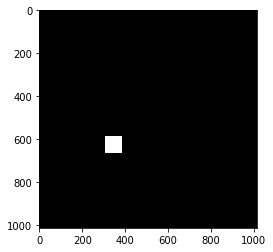

In [8]:
plt.imshow(targets_bin, cmap='gray')

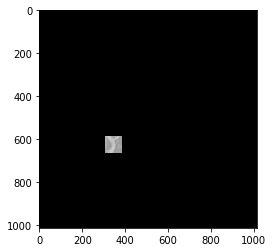

In [9]:
plt.imshow(targets, cmap='gray')

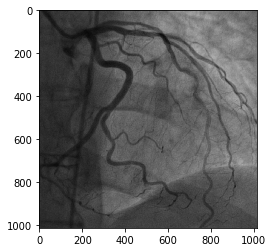

In [10]:
plt.imshow(inputs, cmap='gray')

# UNet

## Dataloaders

In [11]:
os.getcwd()

'/home/raes/Project2/data/targets2'

In [12]:
os.chdir('/home/raes/Project2/')
from torch.utils.data import DataLoader
class Dataset(torch.utils.data.Dataset):
  #'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),   
                            transforms.RandomResizedCrop(224),
                            transforms.RandomRotation(degrees=90),                           
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        #if ID != '.ipynb_checkpoints':

        # Load data and get label
        X = torch.Tensor(np.transpose(np.array(Image.open('data/inputs2/'+ID)),(2,1,0)))
        y = self.labels['tar_'+ID]

        return X, y

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:3" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}
max_epochs = 2

# Datasets
partition = {}
data_id=[ id_image for id_image in os.listdir('data/inputs2/') if id_image != '.ipynb_checkpoints']
partition['train'] = data_id[:len(data_id)-30]
partition['validation'] = data_id[len(data_id)-30:]

labels = {}
for id_image in os.listdir('data/targets2/'):
    if id_image != '.ipynb_checkpoints':
        labels[id_image] = torch.Tensor(np.array(Image.open('data/targets2/'+id_image)))
        #print(labels[id_image].shape)
#I think the error is here, like labels are not pytorch anymore
    
#[1014,1014,3] to [3,1014,1014]
# Generators


training_set = Dataset(partition['train'], labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)
batch_size=2
dataloaders = {
    'train': torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'validation': torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=0)
    #'labels' : torch.utils.data.DataLoader(labels)
    }
#print(len(torch.utils.data.DataLoader(labels)))
dataset_sizes = {x: len(partition[x]) for x in ['train', 'validation']}

## UNet architecture

In [13]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.dwn_conv1 = dual_conv(3,64) #dwn_conv1 contains the 2 conv2D with relu activation function
        self.dwn_conv2 = dual_conv(64, 128)
        self.dwn_conv3 = dual_conv(128,256)
        self.dwn_conv4 = dual_conv(256, 512)
        self.dwn_conv5 = dual_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #right side
        
        self.trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1=dual_conv(1024, 512)
        
        self.trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2=dual_conv(512, 256)
        
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3=dual_conv(256, 128)
        
        self.trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4=dual_conv(128, 64)
        
        self.out1 = nn.Conv2d(64, 1, kernel_size=1, padding=3)
        self.out = nn.Sigmoid()
    def forward(self, image): 
        
        #left side 
        x1=self.dwn_conv1(image)
        x2=self.maxpool(x1)
        x3=self.dwn_conv2(x2)
        x4=self.maxpool(x3)
        x5=self.dwn_conv3(x4)
        x6=self.maxpool(x5)
        x7=self.dwn_conv4(x6)
        x8=self.maxpool(x7)
        x9=self.dwn_conv5(x8)
        
        #forward pass for Right side
        x = self.trans1(x9)
        y = crop_tensor(x, x7)
        x = self.up_conv1(torch.cat([x,y], 1))

        x = self.trans2(x)
        y = crop_tensor(x, x5)
        x = self.up_conv2(torch.cat([x,y], 1))

        x = self.trans3(x)
        y = crop_tensor(x, x3)
        x = self.up_conv3(torch.cat([x,y], 1))

        x = self.trans4(x)
        y = crop_tensor(x, x1)
        x = self.up_conv4(torch.cat([x,y], 1))
        
        
        x = self.out1(x)
        x=self.out(x)
        return x

### Extra functions

In [14]:

def dice_loss(pred, target, smooth = 1.):
    iflat = pred.contiguous().view(-1)
    
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
   

    A_sum = torch.sum(tflat * iflat) 
   
    B_sum = torch.sum(tflat * tflat)
   
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
    

def dual_conv(in_channel, out_channel):
    conv=nn.Sequential(
        nn.Conv2d(in_channel,out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3,padding=1),
        nn.ReLU(inplace=True))
    
    return conv

def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
   
    delta = tensor_size - target_size
    delta = delta // 2
    if 2*delta<tensor_size - target_size: 
        return tensor[:, :, delta:tensor_size- delta -1, delta:tensor_size-delta-1]
    else:
        return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]


In [15]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model = Unet()
model = model.to(device)



## Train the model

In [16]:
from collections import defaultdict
import torch.nn.functional as F
from torchvision import datasets, models, transforms


def calc_loss(pred, target, bce_weight=0.5 ):
    
    #bce = F.binary_cross_entropy_with_logits(pred, target)

    #pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    #loss = bce 
    #* bce_weight + dice * (1 - bce_weight)
    #segloss=
    
    #metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    #metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return dice

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            correct = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels=labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs=outputs.to(device)
                    
                    
                    loss = calc_loss(outputs[0], labels[0])
                    _, preds = torch.max(outputs, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) #.item()
                correct += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = correct.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

#num_class = 1
#model = ResNetUNet(num_class).to(device)
model = Unet().to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.5)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=4)

cuda:3
Epoch 0/3
----------
train Loss: 0.9971 Acc: 1021180.8820
validation Loss: 1.0000 Acc: 1021185.0000

Epoch 1/3
----------
train Loss: 1.0000 Acc: 1021180.8820
validation Loss: 1.0000 Acc: 1021185.0000

Epoch 2/3
----------
train Loss: 1.0000 Acc: 1021180.8820
validation Loss: 1.0000 Acc: 1021185.0000

Epoch 3/3
----------
train Loss: 1.0000 Acc: 1021180.8820
validation Loss: 1.0000 Acc: 1021185.0000

Training complete in 6m 35s
Best val Acc: 0.000000


## *Visualize the input, output and target*

In [18]:
inputs, targets = next(iter(dataloaders['validation']))

output=model(inputs.to(device))


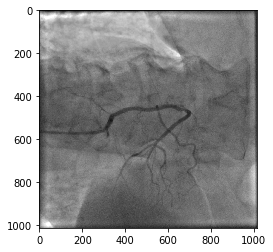

In [19]:

plt.imshow(inputs[0][1].cpu().detach().numpy(), cmap="gray")


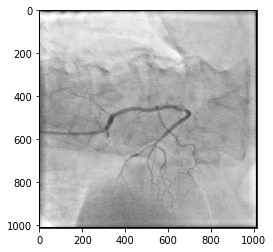

In [20]:
plt.imshow(output[0][0].cpu().detach().numpy(), cmap="gray")

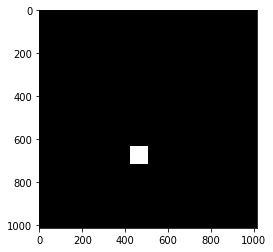

In [21]:
plt.imshow(targets[0].cpu().detach().numpy(), cmap="gray")